In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Model, regularizers
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD
from sklearn.metrics import confusion_matrix,classification_report
from keras.models import Sequential


In [2]:
train_dir = 'dataset/train'
test_dir = 'dataset/test'
val_dir= 'dataset/val'

In [3]:
Image_size = 224
input_shape = (224,224,3)

def scalar(img):
    return img


tr_gen = ImageDataGenerator(preprocessing_function=scalar,
                            horizontal_flip=True,
                            vertical_flip=True)


train_gen = tr_gen.flow_from_directory(
              directory = os.path.join(train_dir),
              target_size=(Image_size,Image_size),
              batch_size =32,shuffle=True,
             class_mode='categorical')

test_gen = ImageDataGenerator(preprocessing_function=scalar).flow_from_directory(
              directory = os.path.join(test_dir),
              target_size=(Image_size,Image_size),
              batch_size =32,shuffle=True,
             class_mode='categorical')

val_gen = ImageDataGenerator(preprocessing_function=scalar).flow_from_directory(
              directory = os.path.join(val_dir),
              target_size=(Image_size,Image_size),
              batch_size =32,shuffle=True,
             class_mode='categorical')

Found 154 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Found 44 images belonging to 3 classes.


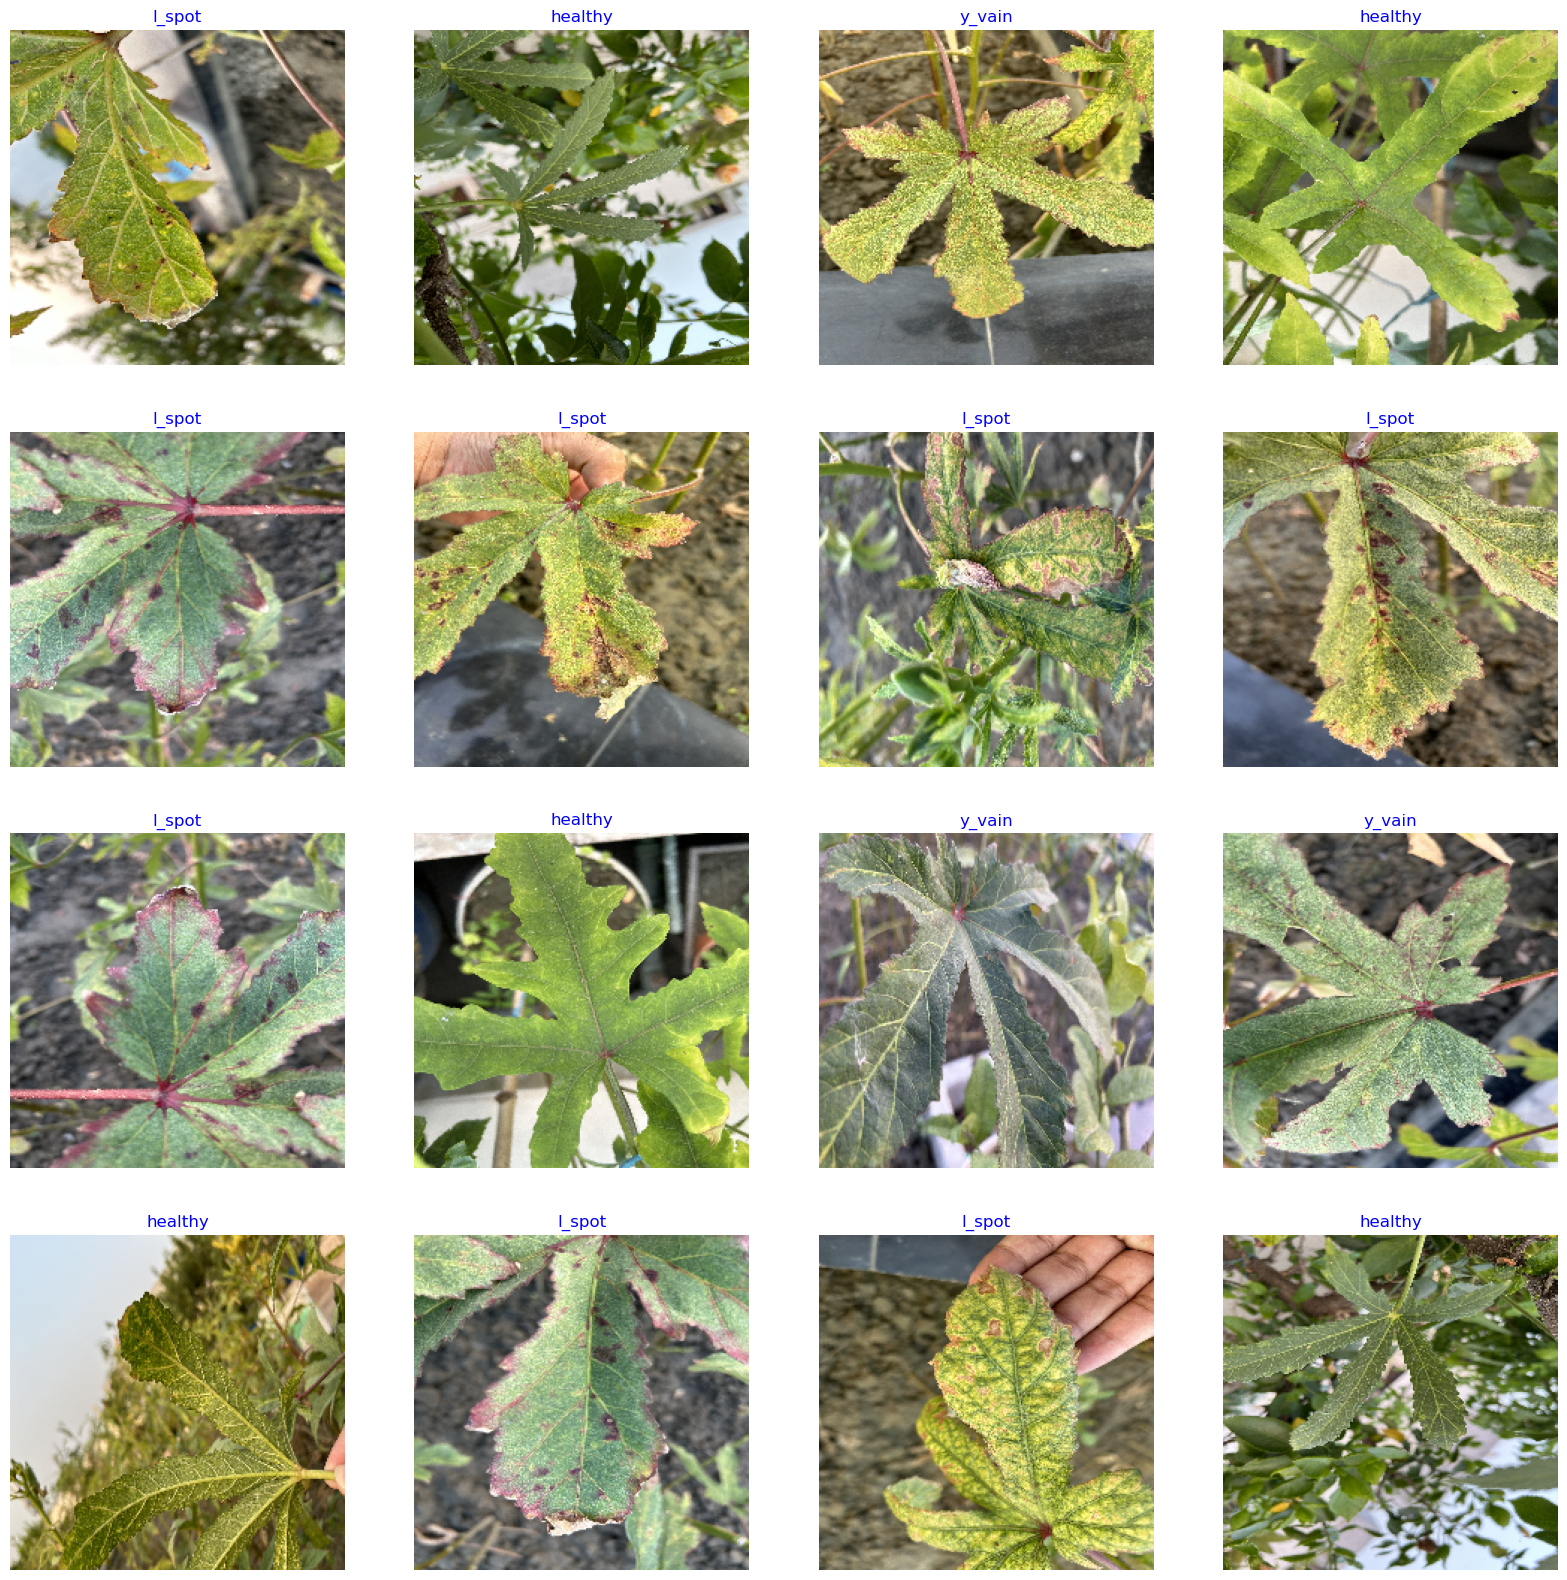

In [4]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]   /255   # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

In [5]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

for layer in base_model.layers:
    layer.trainable= False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 11,183,922
Trainable params: 397,315
Non-trainable params: 10,786,607
______________________________________

In [6]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=50,
                    verbose=True)

Epoch 1/50
3/5 [=================>............] - ETA: 6s - loss: 9.2897 - accuracy: 0.4222 

UnknownError: Graph execution error:

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000018506904630>
Traceback (most recent call last):

  File "C:\Users\ashis\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)

  File "C:\Users\ashis\anaconda3\envs\tf\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\ashis\anaconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1030, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\ashis\anaconda3\envs\tf\lib\site-packages\keras\engine\data_adapter.py", line 831, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\ashis\anaconda3\envs\tf\lib\site-packages\keras\engine\data_adapter.py", line 957, in generator_fn
    yield x[i]

  File "C:\Users\ashis\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py", line 110, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\ashis\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py", line 337, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\ashis\anaconda3\envs\tf\lib\site-packages\keras\utils\image_utils.py", line 394, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "C:\Users\ashis\anaconda3\envs\tf\lib\site-packages\PIL\Image.py", line 3498, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000018506904630>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_24183]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(test_gen)

In [ ]:
predictions =model.predict(test_gen)

In [ ]:
predictions[:5]

In [ ]:
y_test = []
y_test_int = []
for i in tqdm(range(len(test_gen))):
    y_test += test_gen[i][1].tolist()
    y_test_int += test_gen[i][1].argmax(axis=1).tolist()
y_test = np.array(y_test)
y_test_int = np.array(y_test_int)

In [ ]:
y_pred_test = model.predict(test_gen, verbose=1)
y_pred_test_int = y_pred_test.argmax(axis=1)
print(y_pred_test,y_pred_test_int)

In [ ]:
# Define target names
target_names = ['healthy', 'l_spot', 'y_vain']
# Print classification report
print(classification_report(y_test_int, y_pred_test_int, target_names=target_names))

# Generate confusion matrix
cm = confusion_matrix(y_test_int, y_pred_test_int)

# Plot confusion matrix using the blue colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()


In [ ]:
# model.save_weights('saved_model/effnetb3_weight.h5')